# Example for option price models

In [1]:
%load_ext autoreload
%autoreload 2

import price_models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

### We define both a call and a put option 

In [2]:
strike = 105
bsm_call = price_models.BlackScholesModel(strike, "C") # Call option
bsm_put  = price_models.BlackScholesModel(strike, "P") # Put option

### Furthermore, we can compute its value according to the option pricing model

In [3]:
S0 = 100
T = 1/12 # 1 month out
vol = 0.14
r = 0.05

bsm_call.value(S0, T, vol, r), bsm_put.value(S0, T, vol, r)

(28.122556195157422, 484.4635755688117)

### We plot a series of spot prices `S0` for different expiration times `T`

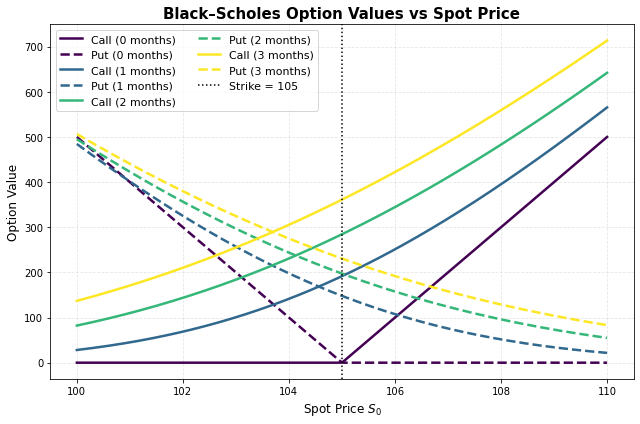

In [4]:
# Parameters
S0_arr = np.linspace(100, 110, 200)  # spot prices
vol = 0.14
r = 0.05
T_arr = np.array([0, 1, 2, 3]) / 12   # 1, 2, 3 months in years
strike = 105  # strike

# Colormap for different maturities
colors = cm.viridis(np.linspace(0, 1, len(T_arr)))

plt.figure(figsize=(9, 6))

for i, T in enumerate(T_arr):
    call_vals = bsm_call.value(S0_arr, T, vol, r)
    put_vals = bsm_put.value(S0_arr, T, vol, r)

    # same color, solid = call, dashed = put
    plt.plot(S0_arr, call_vals, color=colors[i], linestyle="-", linewidth=2.5, label=f"Call ({i} months)")
    plt.plot(S0_arr, put_vals, color=colors[i], linestyle="--", linewidth=2.5, label=f"Put ({i} months)")
 
# Strike reference line
plt.axvline(strike, color="black", linestyle=":", linewidth=1.5, label=f"Strike = {strike}")

# Formatting
plt.title("Black–Scholes Option Values vs Spot Price", fontsize=15, weight="bold")
plt.xlabel("Spot Price $S_0$", fontsize=12)
plt.ylabel("Option Value", fontsize=12)
plt.grid(alpha=0.3, linestyle="--")
plt.legend(fontsize=11, ncol=2)
plt.tight_layout()
plt.show()